In [45]:
import os
import pathlib

import pytest
import numpy as np
import pandas as pd
import math
import xarray as xr
from shapely.geometry import Point, Polygon
from shapely.geometry import LineString
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.ops import cascaded_union, unary_union

import FINE.spagat.representation as spr
import FINE.spagat.grouping as spg
import FINE.spagat.dataset as spd
import FINE.spagat.utils as spu

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
component_list = ['c1','c2']  
space_list = ['01_reg','02_reg','03_reg','04_reg']
TimeStep_list = ['T0','T1']
Period_list = [0]

## ts variable data
test_ts_data = np.array([ [ [ [5, 5, 5, 5] for i in range(2)] ],

                      [ [[np.nan, np.nan, np.nan, np.nan] for i in range(2)] ]

                      ])

test_ts_DataArray = xr.DataArray(test_ts_data, 
                              coords=[component_list, Period_list, TimeStep_list, space_list], 
                              dims=['component', 'Period', 'TimeStep','space'])

## 1d variable data
test_1d_data = np.array([ [5,  5,  5, 5],
                        [np.nan] *4
                      ])

test_1d_DataArray = xr.DataArray(test_1d_data, 
                          coords=[component_list, space_list], 
                          dims=['component', 'space'])

## 2d variable data
test_2d_data = np.array([ [[ 0,  5,  5, 5],
                      [ 5,  0,  5, 5],
                      [ 5,  5,  0, 5],
                      [ 5,  5,  5, 0]],

                    [[np.nan] * 4 for i in range(4)] 
                    ])

test_2d_DataArray = xr.DataArray(test_2d_data, 
                          coords=[component_list, space_list, space_list], 
                          dims=['component', 'space', 'space_2'])

test_ds = xr.Dataset({'var_ts': test_ts_DataArray, 
                    'var_1d': test_1d_DataArray,
                    'var_2d': test_2d_DataArray})    

sds = spd.SpagatDataset()
sds.xr_dataset = test_ds            

test_geometries = [Polygon([(0,0), (2,0), (2,2), (0,2)]),
                Polygon([(2,0), (4,0), (4,2), (2,2)]),
                Polygon([(0,0), (4,0), (4,4), (0,4)]),
                Polygon([(0,0), (1,0), (1,1), (0,1)])]   

sds.add_objects(description ='gpd_geometries',   #NOTE: not sure if it is ok to call another function here
            dimension_list =['space'], 
            object_list = test_geometries)

In [ ]:
sds.xr_dataset = sds.xr_dataset.rename({'var_2d':'2d_locationalEligibility'})

In [47]:
file_path="C:/Users/s.patil/Documents/code/fine/test/spagat/data/output"
files_name = "AC_lines",
spatial_dim="space"
eligibility_variable="2d_locationalEligibility"
eligibility_component='c1'

In [48]:
spr.add_region_centroids(sds)

In [49]:
buses_0 = []
buses_1 = []
geoms = []

In [50]:
if eligibility_component is not None:
    eligibility_xr_array = sds.xr_dataset[eligibility_variable].sel(
        component=eligibility_component
    )
else:
    eligibility_xr_array = sds.xr_dataset[eligibility_variable]  

In [51]:
for region_id_1 in sds.xr_dataset[f"{spatial_dim}"].values:
    for region_id_2 in sds.xr_dataset[f"{spatial_dim}_2"].values:
        if eligibility_xr_array.sel(space=region_id_1, space_2=region_id_2).values: 
            buses_0.append(region_id_1)
            buses_1.append(region_id_2)

            point_1 = sds.xr_dataset.gpd_centroids.sel(space=region_id_1).item(0)
            point_2 = sds.xr_dataset.gpd_centroids.sel(space=region_id_2).item(0)
            line = LineString([(point_1.x, point_1.y), (point_2.x, point_2.y)])

            geoms.append(line)

In [52]:
# TODO: understand what s_nom and x stand for (look into FINE?) and add or delete them below
df = pd.DataFrame(
    {
        "bus0": buses_0,
        "bus1": buses_1,
        #      's_nom': ,
        #      'x': ,
    }
)

In [53]:
geoms

In [54]:
df

,bus0,bus1
0,01_reg,02_reg
1,01_reg,03_reg
2,01_reg,04_reg
3,02_reg,01_reg
4,02_reg,03_reg
5,02_reg,04_reg
6,03_reg,01_reg
7,03_reg,02_reg
8,03_reg,04_reg
9,04_reg,01_reg


In [55]:
gdf = spu.create_gdf(df, geoms)

In [56]:
gdf

,bus0,bus1,geometry
0,01_reg,02_reg,"LINESTRING (1.00000 1.00000, 3.00000 1.00000)"
1,01_reg,03_reg,"LINESTRING (1.00000 1.00000, 2.00000 2.00000)"
2,01_reg,04_reg,"LINESTRING (1.00000 1.00000, 0.50000 0.50000)"
3,02_reg,01_reg,"LINESTRING (3.00000 1.00000, 1.00000 1.00000)"
4,02_reg,03_reg,"LINESTRING (3.00000 1.00000, 2.00000 2.00000)"
5,02_reg,04_reg,"LINESTRING (3.00000 1.00000, 0.50000 0.50000)"
6,03_reg,01_reg,"LINESTRING (2.00000 2.00000, 1.00000 1.00000)"
7,03_reg,02_reg,"LINESTRING (2.00000 2.00000, 3.00000 1.00000)"
8,03_reg,04_reg,"LINESTRING (2.00000 2.00000, 0.50000 0.50000)"
9,04_reg,01_reg,"LINESTRING (0.50000 0.50000, 1.00000 1.00000)"


In [26]:
spr.create_grid_shapefile(sds,
                          file_path="C:/Users/s.patil/Documents/code/fine/test/spagat/data/output",
                          files_name="AC_lines",
                        spatial_dim="space",
                        eligibility_variable="2d_locationalEligibility",
                        eligibility_component='c1')

In [28]:
dummy_map = gpd.read_file("C:/Users/s.patil/Documents/code/fine/test/spagat/data/output/AC_lines.shp")

In [30]:
dummy_map

,FID,geometry
0,0,"LINESTRING (1.00000 1.00000, 3.00000 1.00000)"
1,1,"LINESTRING (1.00000 1.00000, 2.00000 2.00000)"
2,2,"LINESTRING (1.00000 1.00000, 0.50000 0.50000)"
3,3,"LINESTRING (3.00000 1.00000, 1.00000 1.00000)"
4,4,"LINESTRING (3.00000 1.00000, 2.00000 2.00000)"
5,5,"LINESTRING (3.00000 1.00000, 0.50000 0.50000)"
6,6,"LINESTRING (2.00000 2.00000, 1.00000 1.00000)"
7,7,"LINESTRING (2.00000 2.00000, 3.00000 1.00000)"
8,8,"LINESTRING (2.00000 2.00000, 0.50000 0.50000)"
9,9,"LINESTRING (0.50000 0.50000, 1.00000 1.00000)"


<AxesSubplot:>

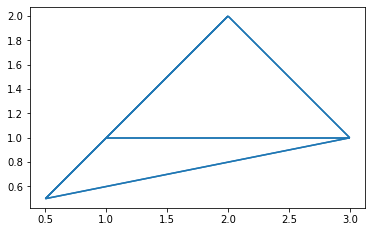

In [29]:
dummy_map.plot()